In [74]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

In [75]:
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=1)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-27 02:07:27,984] A new study created in memory with name: no-name-ef8bb45c-dbd6-406e-b3c8-106a048b53d3
[I 2024-05-27 02:07:33,826] Trial 2 finished with value: 0.3574685735617792 and parameters: {'n_estimators': 81, 'learning_rate': 0.007187853599155134, 'gamma': 0.3650637386043922, 'max_depth': 34, 'booster': 'dart'}. Best is trial 2 with value: 0.3574685735617792.
[I 2024-05-27 02:07:37,431] Trial 4 finished with value: 0.42142137476115005 and parameters: {'n_estimators': 338, 'learning_rate': 0.0012562147558187386, 'gamma': 0.10910928048868973, 'max_depth': 32, 'booster': 'gbtree'}. Best is trial 2 with value: 0.3574685735617792.
[I 2024-05-27 02:07:37,460] Trial 1 finished with value: 0.13862584629199495 and parameters: {'n_estimators': 771, 'learning_rate': 0.001980569062512683, 'gamma': 0.134497345097046, 'max_depth': 23, 'booster': 'dart'}. Best is trial 1 with value: 0.13862584629199495.
[I 2024-05-27 02:07:37,795] Trial 3 finished with value: 0.2083032366441025 and 

Best hyperparameters: {'n_estimators': 1929, 'learning_rate': 0.06189715702282267, 'gamma': 0.010176209471841948, 'max_depth': 25, 'booster': 'gbtree'}
Best RMSE: 0.037549976260145765


In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
aa=xgb.XGBRegressor(n_estimators=1968, max_depth=41, learning_rate=0.0611375206402976, booster='dart', gamma=0.010175790175556318)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)

df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'XGB_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


MAPE 0.035561848397404894
MAPE 0.023438774114538843
MAPE 0.08544058970403484
Data exported to XGB_shear.xlsx


In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-27 02:22:34,386] A new study created in memory with name: no-name-745c009c-81ff-4b5c-85ff-7080b214f7dd
[I 2024-05-27 02:22:50,295] Trial 1 finished with value: 0.03829927668831477 and parameters: {'n_estimators': 1676, 'learning_rate': 0.0032615169138667357, 'max_depth': 18, 'num_leaves': 31, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.03829927668831477.
[I 2024-05-27 02:22:51,171] Trial 2 finished with value: 0.0558301478462375 and parameters: {'n_estimators': 1217, 'learning_rate': 0.022790973890854545, 'max_depth': 46, 'num_leaves': 21, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.03829927668831477.
[I 2024-05-27 02:22:54,025] Trial 6 finished with value: 0.03639373808779781 and parameters: {'n_estimators': 117, 'learning_rate': 0.123004929253571, 'max_depth': 38, 'num_leaves': 22, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.03639373808779781.
[I 2024-05-27 02:22:54,641] Trial 4 finished with value: 0.03707971732353299 and parameters: {'

Best hyperparameters: {'n_estimators': 1096, 'learning_rate': 0.032981431608031894, 'max_depth': 29, 'num_leaves': 10, 'boosting_type': 'gbdt'}
Best RMSE: 0.034463613755135


In [6]:
#{'n_estimators': 852, 'learning_rate': 0.0011233649860397813, 'max_depth': 25, 'num_leaves': 10, 'boosting_type': 'dart'}
#Best hyperparameters: {'n_estimators': 637, 'learning_rate': 0.1600399958968201, 'max_depth': 35, 'num_leaves': 10, 'boosting_type': 'dart'}
#Best hyperparameters: {'n_estimators': 1263, 'learning_rate': 0.1999463922321262, 'max_depth': 43, 'num_leaves': 10, 'boosting_type': 'dart'}
from lightgbm.sklearn import LGBMRegressor
aa=LGBMRegressor(n_estimators=1972,learning_rate=0.03292990236538229, max_depth=50, num_leaves= 10, boosting_type='gbdt')
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'LGBM_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 672, number of used features: 13
[LightGBM] [Info] Start training from score 1.439374
MAPE 0.0355900640422767
MAPE 0.017363868556013705
MAPE 0.0653313188413842
Data exported to LGBM_shear.xlsx


In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-27 02:29:14,669] A new study created in memory with name: no-name-a11f8b6f-e6fc-4ffc-bd97-3a837ccafbce
[I 2024-05-27 02:29:17,154] Trial 1 finished with value: 0.08135811243045017 and parameters: {'n_estimators': 256, 'max_depth': 28, 'min_samples_leaf': 46, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.08135811243045017.
[I 2024-05-27 02:29:17,862] Trial 0 finished with value: 0.05383565414209639 and parameters: {'n_estimators': 1114, 'max_depth': 35, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.05383565414209639.
[I 2024-05-27 02:29:19,740] Trial 2 finished with value: 0.07874417980924489 and parameters: {'n_estimators': 192, 'max_depth': 3, 'min_samples_leaf': 33, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.05383565414209639.
[I 2024-05-27 02:29:21,279] Trial 5 finished with value: 0.06304342755616729 and parameters: {'n_estimators': 346, 'max_depth': 27, 'min_

Best hyperparameters: {'n_estimators': 1403, 'max_depth': 39, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.04300362306237412


In [71]:
from sklearn.ensemble import RandomForestRegressor
#Best hyperparameters: {'n_estimators': 336, 'max_depth': 48, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
aa=RandomForestRegressor(random_state=1000,n_estimators=1134, max_depth=22, min_samples_leaf=2, max_features='log2', bootstrap=False)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'RF_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.04309924033567181


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAPE 0.043241996559240006
MAPE 0.023612460020040037
MAPE 0.08741967516420014
Data exported to RF_shear.xlsx


In [79]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-27 02:38:56,413] A new study created in memory with name: no-name-c00c6bf6-2135-4d64-9c09-108d6a360d46
[I 2024-05-27 02:41:51,794] Trial 0 finished with value: 0.03689171937222625 and parameters: {'iterations': 1776, 'learning_rate': 0.05020802463806653, 'depth': 9, 'subsample': 0.1721928566715808, 'colsample_bylevel': 0.8652574712520467, 'min_data_in_leaf': 53}. Best is trial 0 with value: 0.03689171937222625.
[I 2024-05-27 02:45:37,518] Trial 4 finished with value: 0.03687504461375017 and parameters: {'iterations': 687, 'learning_rate': 0.025529936927222593, 'depth': 5, 'subsample': 0.9733485316220183, 'colsample_bylevel': 0.8062482659446139, 'min_data_in_leaf': 55}. Best is trial 4 with value: 0.03687504461375017.
[I 2024-05-27 02:47:58,297] Trial 1 finished with value: 0.05575068112955715 and parameters: {'iterations': 1399, 'learning_rate': 0.001968412440891589, 'depth': 7, 'subsample': 0.3864672458241408, 'colsample_bylevel': 0.6584351512989396, 'min_data_in_leaf': 88}

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [80]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-27 05:48:23,026] A new study created in memory with name: no-name-f773bea9-8e47-472c-bc0f-614637538971
[I 2024-05-27 05:48:51,943] Trial 2 finished with value: 0.03600903342753829 and parameters: {'iterations': 1152, 'learning_rate': 0.0836477963030431, 'depth': 16, 'subsample': 0.3820841233651573, 'colsample_bylevel': 0.09982139277920477, 'min_data_in_leaf': 45}. Best is trial 2 with value: 0.03600903342753829.
[I 2024-05-27 05:48:55,302] Trial 9 finished with value: 0.03454029480353899 and parameters: {'iterations': 1921, 'learning_rate': 0.07941951470515471, 'depth': 3, 'subsample': 0.7727132519133724, 'colsample_bylevel': 0.38001818910761903, 'min_data_in_leaf': 81}. Best is trial 9 with value: 0.03454029480353899.
[I 2024-05-27 05:49:23,306] Trial 12 finished with value: 0.04649345893095001 and parameters: {'iterations': 1937, 'learning_rate': 0.016503618726238373, 'depth': 1, 'subsample': 0.605247031168334, 'colsample_bylevel': 0.8433043429097491, 'min_data_in_leaf': 2

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [29]:
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=1)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-25 04:43:55,867] A new study created in memory with name: no-name-70576c96-15de-4ed8-ada9-5c759cfee661
[I 2024-05-25 04:44:08,417] Trial 12 finished with value: 0.06191110582149233 and parameters: {'iterations': 232, 'learning_rate': 0.01698301822282145, 'depth': 3, 'subsample': 0.36339715036474474, 'colsample_bylevel': 0.31385062441836675, 'min_data_in_leaf': 50}. Best is trial 12 with value: 0.06191110582149233.
[I 2024-05-25 04:44:13,099] Trial 3 finished with value: 0.03811332534139265 and parameters: {'iterations': 1649, 'learning_rate': 0.05233442317899121, 'depth': 9, 'subsample': 0.30642796246450804, 'colsample_bylevel': 0.12970470658627684, 'min_data_in_leaf': 90}. Best is trial 3 with value: 0.03811332534139265.
[I 2024-05-25 04:44:20,181] Trial 2 finished with value: 0.03855048855534952 and parameters: {'iterations': 754, 'learning_rate': 0.03980183961322312, 'depth': 8, 'subsample': 0.9666364476714976, 'colsample_bylevel': 0.4259826696957947, 'min_data_in_leaf': 

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [30]:
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=1)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-25 08:12:07,915] A new study created in memory with name: no-name-860d7969-27c5-4d00-8947-f354b9db0fa7
[I 2024-05-25 08:12:50,860] Trial 3 finished with value: 0.05052037663960215 and parameters: {'iterations': 364, 'learning_rate': 0.016810952081164315, 'depth': 8, 'subsample': 0.8887403223294478, 'colsample_bylevel': 0.1748025549649656, 'min_data_in_leaf': 5}. Best is trial 3 with value: 0.05052037663960215.
[I 2024-05-25 08:13:46,772] Trial 5 finished with value: 0.05518503145549003 and parameters: {'iterations': 1458, 'learning_rate': 0.002644805955857523, 'depth': 6, 'subsample': 0.47552912180689616, 'colsample_bylevel': 0.2563181147467285, 'min_data_in_leaf': 62}. Best is trial 3 with value: 0.05052037663960215.
[I 2024-05-25 08:13:56,194] Trial 13 finished with value: 0.07183063574824104 and parameters: {'iterations': 270, 'learning_rate': 0.005731349499654624, 'depth': 6, 'subsample': 0.9448916644155654, 'colsample_bylevel': 0.3001717615013478, 'min_data_in_leaf': 46

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-05-24 21:34:43,558] A new study created in memory with name: no-name-cdeb5386-ee87-4831-9e5a-d934fd997a49


[I 2024-05-24 21:34:44,601] Trial 0 finished with value: 0.0816982114692695 and parameters: {'n_estimators': 171, 'max_depth': 23, 'min_samples_leaf': 35, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.0816982114692695.
[I 2024-05-24 21:34:45,457] Trial 1 finished with value: 0.05684866082493387 and parameters: {'n_estimators': 441, 'max_depth': 26, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.05684866082493387.
[I 2024-05-24 21:34:47,532] Trial 3 finished with value: 0.0723510630609106 and parameters: {'n_estimators': 1657, 'max_depth': 19, 'min_samples_leaf': 34, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.05684866082493387.
[I 2024-05-24 21:34:48,415] Trial 4 finished with value: 0.10028124573126859 and parameters: {'n_estimators': 454, 'max_depth': 1, 'min_samples_leaf': 40, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.05684866082493387.
[I 202

Best hyperparameters: {'n_estimators': 336, 'max_depth': 48, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.04562984708551984


In [81]:
#{'iterations': 1706, 'learning_rate': 0.055064666134721316, 'depth': 5, 'subsample': 0.7145542053408417, 'colsample_bylevel': 0.7134376025995272, 'min_data_in_leaf': 6}. Best is trial 425 with value: 0.02792233246641194.
#'iterations': 1169, 'learning_rate': 0.08157904502046057, 'depth': 5, 'subsample': 0.16684649915470987, 'colsample_bylevel': 0.6952707964024957, 'min_data_in_leaf': 21
#'iterations': 951, 'learning_rate': 0.08768907572061921, 'depth': 14, 'subsample': 0.8482714492502392, 'colsample_bylevel': 0.5771984389795453, 'min_data_in_leaf': 3
#{'iterations': 1869, 'learning_rate': 0.0672515096671439, 'depth': 4, 'subsample': 0.4437892719730423, 'colsample_bylevel': 0.8691701591476318, 'min_data_in_leaf': 98}. Best is trial 399 with value: 0.0354329706014585.
#'iterations': 1696, 'learning_rate': 0.09061358851630891, 'depth': 4, 'subsample': 0.38898336774717307, 'colsample_bylevel': 0.7837534206136937, 'min_data_in_leaf': 10}. Best is trial 47 with value: 0.033233125765573954.
# {'iterations': 1847, 'learning_rate': 0.07530763991901157, 'depth': 4, 'subsample': 0.2243561350633582, 'colsample_bylevel': 0.9416932976270314, 'min_data_in_leaf': 50}. Best is trial 131 with value: 0.03351851821292397.

import catboost as cb
aa=cb.CatBoostRegressor(iterations=1847,learning_rate=0.07530763991901157,depth=4,subsample=0.2243561350633582,colsample_bylevel=0.9416932976270314,min_data_in_leaf= 50)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE train',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE test',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000

filename = 'Cat_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1837083	total: 7.45ms	remaining: 13.8s
1:	learn: 0.1795414	total: 8.96ms	remaining: 8.26s
2:	learn: 0.1738814	total: 9.75ms	remaining: 6s
3:	learn: 0.1685955	total: 10.5ms	remaining: 4.82s
4:	learn: 0.1638623	total: 11.4ms	remaining: 4.22s
5:	learn: 0.1600457	total: 12.1ms	remaining: 3.71s
6:	learn: 0.1557730	total: 12.6ms	remaining: 3.3s
7:	learn: 0.1523762	total: 13.2ms	remaining: 3.04s
8:	learn: 0.1496592	total: 13.8ms	remaining: 2.81s
9:	learn: 0.1461016	total: 14.6ms	remaining: 2.68s
10:	learn: 0.1433660	total: 15ms	remaining: 2.51s
11:	learn: 0.1405958	total: 15.5ms	remaining: 2.37s
12:	learn: 0.1377742	total: 16.3ms	remaining: 2.3s
13:	learn: 0.1352561	total: 16.8ms	remaining: 2.2s
14:	learn: 0.1328588	total: 17.4ms	remaining: 2.12s
15:	learn: 0.1301512	total: 17.9ms	remaining: 2.05s
16:	learn: 0.1282253	total: 18.4ms	remaining: 1.98s
17:	learn: 0.1266691	total: 18.8ms	remaining: 1.91s
18:	learn: 0.1249317	total: 19.3ms	remaining: 1.86s
19:	learn: 0.1226417	total: 19

In [ ]:
import catboost as cb
import optuna
import numpy as np
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
aa=cb.CatBoostRegressor(iterations=1135,learning_rate=0.09342109519812346,depth=15,subsample=0.4715732143809523,colsample_bylevel=0.9427303576347658,min_data_in_leaf= 48)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

In [ ]:
aa=cb.CatBoostRegressor(iterations=1135,learning_rate=0.09342109519812346,depth=15,subsample=0.4715732143809523,colsample_bylevel=0.9427303576347658,min_data_in_leaf= 48)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

In [ ]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'Cat_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']

#PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0

# Create a list to store the statistical properties for each feature
features = ['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


              h         d         b         a       a_d       fck       rho  \
h      1.000000  0.996510  0.506564  0.775548 -0.078762 -0.036644 -0.112919   
d      0.996510  1.000000  0.494773  0.767885 -0.094326 -0.048052 -0.154341   
b      0.506564  0.494773  1.000000  0.651123  0.260055 -0.158690 -0.032796   
a      0.775548  0.767885  0.651123  1.000000  0.488680 -0.053266 -0.005963   
a_d   -0.078762 -0.094326  0.260055  0.488680  1.000000  0.042151  0.239175   
fck   -0.036644 -0.048052 -0.158690 -0.053266  0.042151  1.000000  0.357979   
rho   -0.112919 -0.154341 -0.032796 -0.005963  0.239175  0.357979  1.000000   
fy     0.128059  0.129580  0.184781  0.097184 -0.050814  0.144928 -0.187147   
rho_v -0.098111 -0.101971 -0.118708 -0.081992  0.001595  0.136297  0.210504   
fyv   -0.032842 -0.038739 -0.001166  0.034506  0.101289  0.192422  0.168538   
rho_h  0.001827 -0.001060 -0.197295 -0.104354 -0.195761  0.063594  0.021156   
fyh    0.090561  0.075855 -0.103041  0.053085 -0.067

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

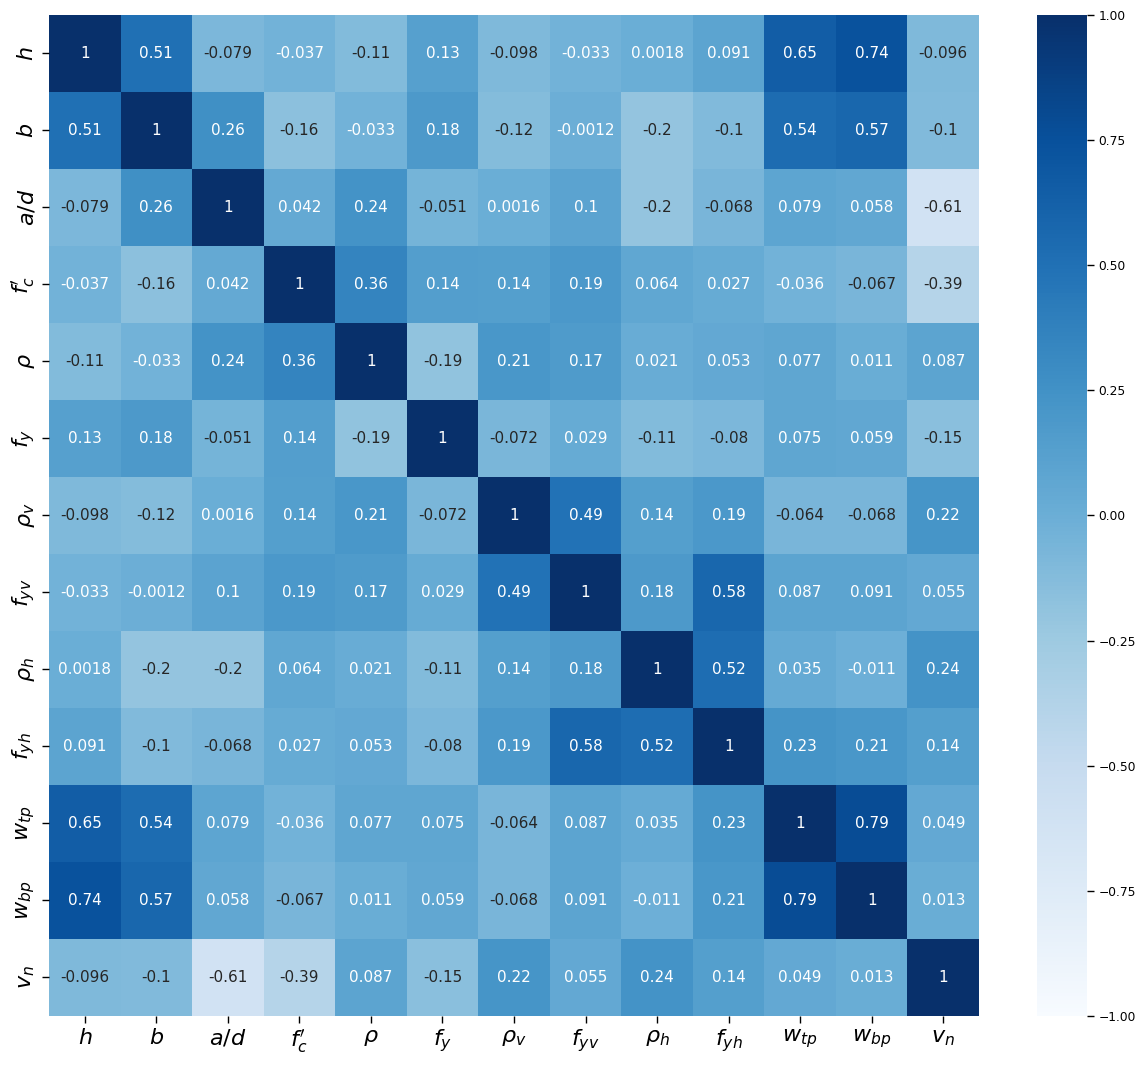

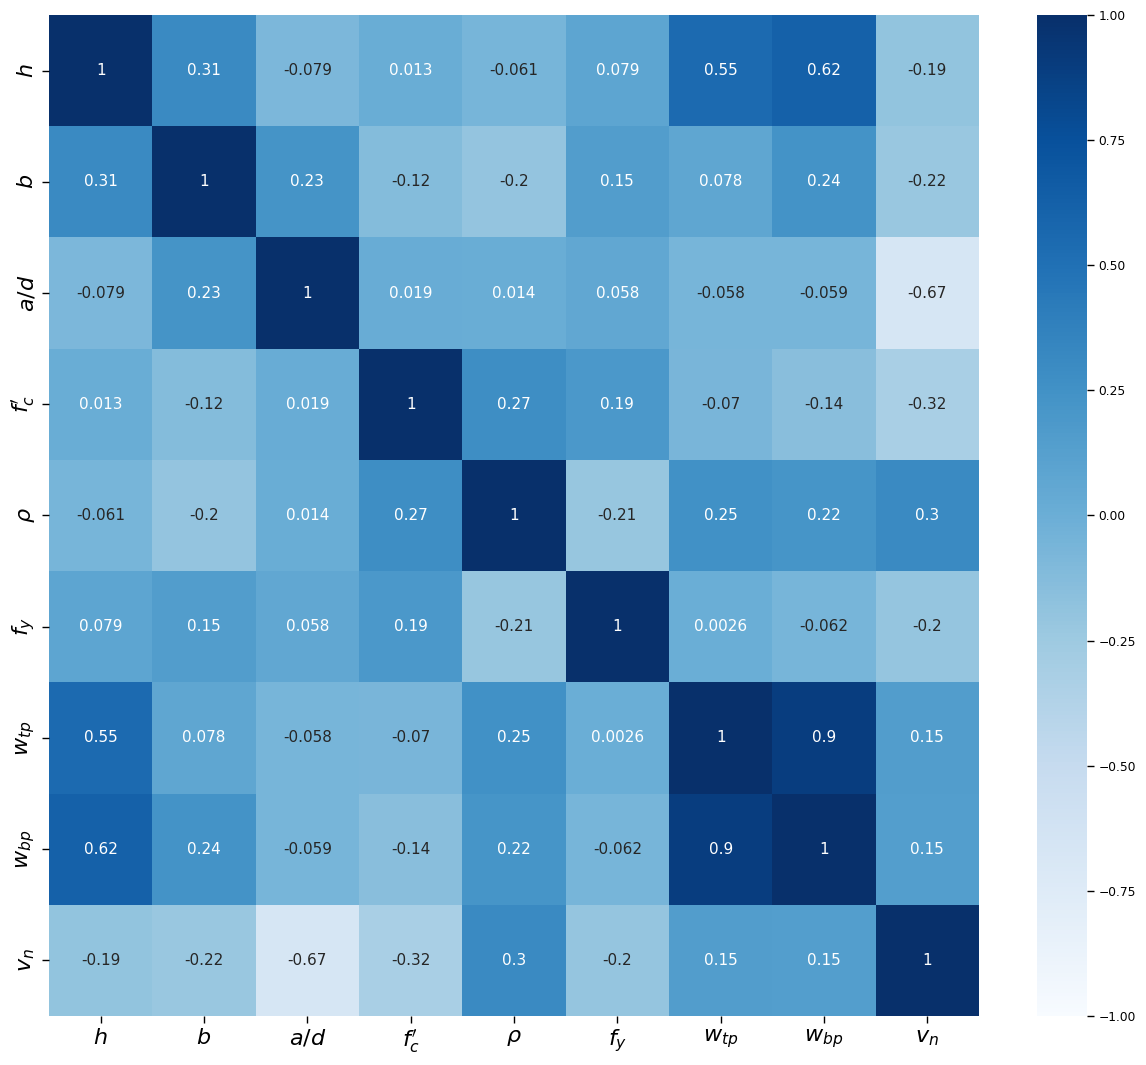

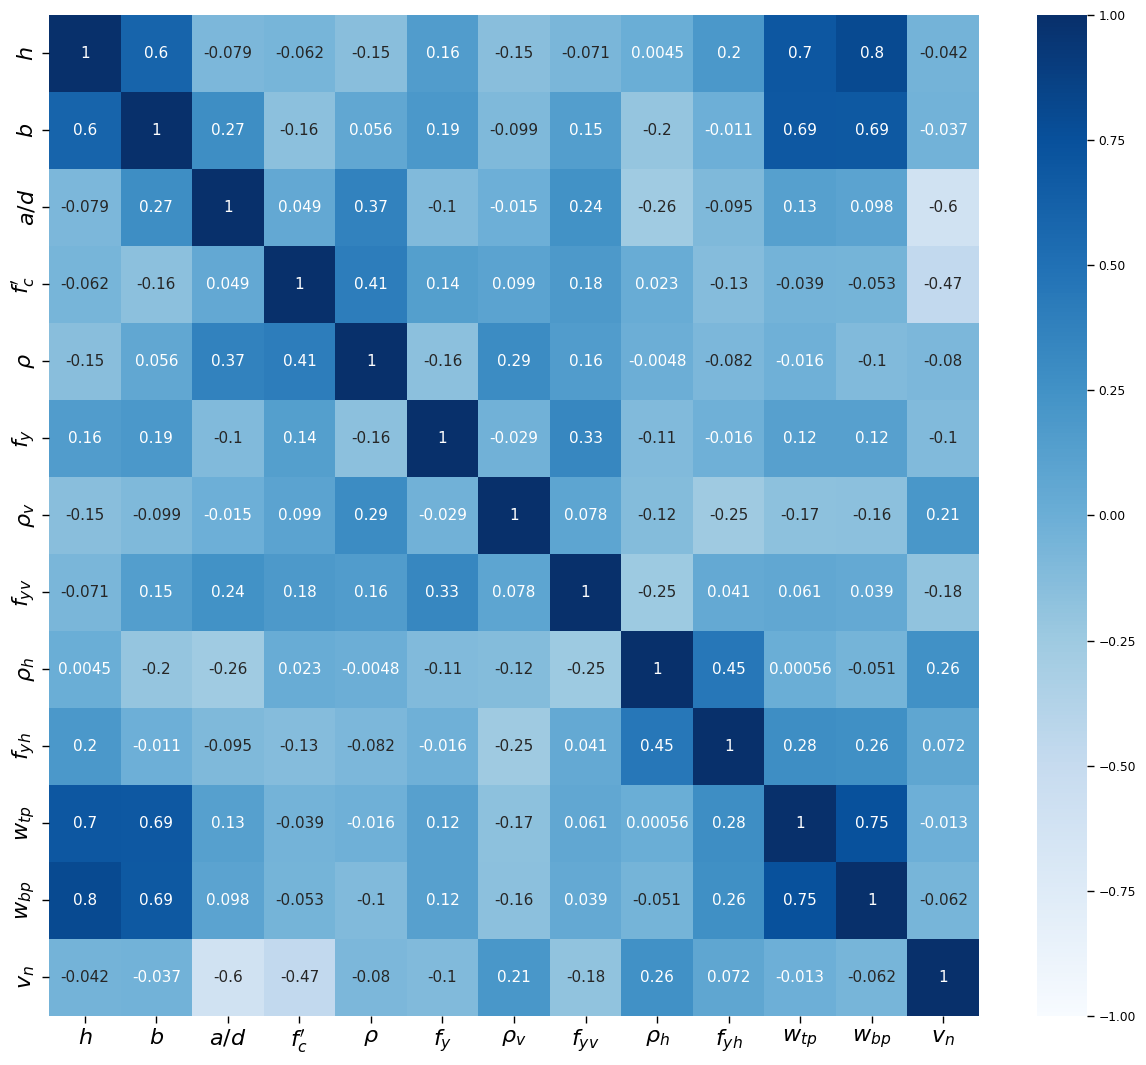

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC = PC[abs(PC['rho_v'] + PC['rho_h']) < 0.00000001]

PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear_without.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC = PC[abs(PC['rho_v'] + PC['rho_h']) > 0.00000001]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear_with.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

SVR

In [82]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
pi = math.pi
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=1)
num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.22019519646211694
Iteration 1: Best Cost = 0.21901880956672404
Iteration 2: Best Cost = 0.21893149513708154
Iteration 3: Best Cost = 0.21881265466794936
Iteration 4: Best Cost = 0.21881265466794936
Iteration 5: Best Cost = 0.21881265466794936
Iteration 6: Best Cost = 0.21881265466794936
Iteration 7: Best Cost = 0.21859412189724728
Iteration 8: Best Cost = 0.21859412189724728
Iteration 9: Best Cost = 0.21859412189724728
Global Best:
{'position': array([  0.99882986, -74.88644548,  -1.72300541]), 'cost': 0.21859412189724728}


In [33]:
math.exp(-74.88644548)

3.000750994389253e-33

In [83]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#0.98377012, -69.37560749,   3.35051143
#increase number of particles from 50 to 500 #0.96109455, -27.71123196,   3.36205192
#[  0.95663944, -61.30657623,   3.36564107]), 'cost': 0.06111466489637234}
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0)
lengthy=len(y_train);print(lengthy)

y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'SVR_shear.xlsx'
df.to_excel(filename, index=False)

print("Data exported to", filename)


0.21859412189724728
0.022594272353739238
672
0.1851961200761367
Data exported to SVR_shear.xlsx


In [ ]:
Iteration 9: Best Cost = 0.24516452242183542
0.24516452242183542
0.01576801282445605
415
0.20100510176575626

Circular

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=1)

Rectangular

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']

X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=1)
'''
gpr = GaussianProcessRegressor(alpha=0.001)#,normalize_y=True
gpr.kernel = ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RBF(length_scale=1.0,length_scale_bounds=(1e-5,1e5))+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.0)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*WhiteKernel(noise_level=0.1)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RationalQuadratic(length_scale=1,alpha=1)
gpr.fit(X_train, y_train.reshape(-1,1))'''

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.002]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [85]:
print(best_alpha)

0.002


In [87]:
# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

In [88]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'Gpr_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

Data exported to Gpr_shear.xlsx


In [91]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.utils.validation import _check_fit_params
from sklearn.utils.metaestimators import _safe_split
rand_stat=1
def cross_val_predict(estimator,X,y=None,*,groups=None,cv=None,n_jobs=None,verbose=0,
    fit_params=None,pre_dispatch="2*n_jobs",method="predict",XX):#XX  is added to crossfold

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    splits = list(cv.split(X, y, groups))
    test_indices = np.concatenate([test for _, test in splits])    
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
    ppp = parallel(
        delayed(_fit_and_predict)(clone(estimator), X, y, train, test, verbose, fit_params, method,XX=XX)
        for train, test in splits)
    
    inv_test_indices = np.empty(len(test_indices), dtype=int)
    inv_test_indices[test_indices] = np.arange(len(test_indices))
    predictions=[];y_pred_tot=[]
    for i in range(len(ppp)):
        predictions.append(ppp[i][0])
        y_pred_tot.append(ppp[i][1])                    #this line is added to crossfold
    pred = np.concatenate(predictions)
    return pred[inv_test_indices],y_pred_tot            #y_pred_tot is added to crossfold
def _fit_and_predict(estimator, X, y, train, test, verbose, fit_params, method,XX):#XX  is added to crossfold
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)

    estimator.fit(X_train, y_train, **fit_params)
    func = getattr(estimator, method)
    predictions = func(X_test)
    p_red = func(XX)                                    #this line is added to crossfold
    return predictions,p_red
nfoldy=5
feature_range=(0,7)
PC  = pd.read_excel('deep_beam2222.xlsx',sheet_name='all')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp']]
y=PC['vn']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)

X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)
model = MLPRegressor(hidden_layer_sizes=5, activation='logistic',max_iter=100000, solver='lbfgs', random_state=1)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=1)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)


#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename ='ML_shear.xlsx'
df.to_excel(filename, index=False)

print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1])) #0.06421353092185479 0.9994000056676541

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklear

0.12766851903360654 0.9954692755424815
